# Project 3
August Noer Steinset

Set up cassandra

In [10]:
import os
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ipywidgets import interact



os.environ["PYSPARK_PYTHON"] = "python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()

Download the data

In [2]:
df = spark.read.format("org.apache.spark.sql.cassandra").options(table="table2", keyspace="project1").load()
# order by week
df = df.orderBy('week')
df = df.toPandas()
df = df.set_index('week')
df['localities'] = df['localities'].apply(json.loads)
df.head()

,localities,year
week,,
1,"[{'localityNo': 14746, 'localityWeekId': 10344...",2020
2,"[{'localityNo': 14746, 'localityWeekId': 10368...",2020
3,"[{'localityNo': 14746, 'localityWeekId': 10401...",2020
4,"[{'localityNo': 14746, 'localityWeekId': 10425...",2020
5,"[{'localityNo': 14746, 'localityWeekId': 10449...",2020


Convert from json to dataframe

In [3]:
# Empty list to collect DataFrames
dfs = []

# Iterate over rows in DataFrame
for index, row in df.iterrows():
    # Create temporary DataFrame based on locality
    temp_df = pd.DataFrame(row['localities'])
    # Add week for reference
    temp_df['week'] = index
    # Append DataFrame to list
    dfs.append(temp_df)

# Concatenate all DataFrames
final_df = pd.concat(dfs, ignore_index=True)

# Display the final DataFrame
final_df.head() 


,localityNo,localityWeekId,name,hasReportedLice,isFallow,avgAdultFemaleLice,hasCleanerfishDeployed,hasMechanicalRemoval,hasSubstanceTreatments,hasPd,hasIla,municipalityNo,municipality,lat,lon,isOnLand,inFilteredSelection,hasSalmonoids,isSlaughterHoldingCage,week
0,14746,1034438,Aarsand,False,True,NaN,False,False,False,False,False,1811,Bindal,65.045867,12.156933,False,True,False,False,1
1,31937,1034808,Abelsnes,False,True,NaN,False,False,False,False,False,4207,Flekkefjord,58.238767,6.656650,True,True,False,False,1
2,10665,1033821,Adamselv,False,True,NaN,False,False,False,False,False,5438,Lebesby,70.408000,26.691333,True,True,True,False,1
3,29196,1034761,Adjetjohka,False,True,NaN,False,False,False,False,False,5430,Guovdageaidnu - Kautokeino,68.944137,22.918715,True,True,False,False,1
4,13823,1034381,Ådlandsvatn,False,True,NaN,False,False,False,False,False,4614,Stord,59.791350,5.500367,True,True,True,False,1


Create a region column

In [4]:
# Create a variable called region, splitting Norway into three regions: South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude
final_df['region'] = np.where(final_df['lat'] < 63.81, 'South', np.where(final_df['lat'] < 68.85, 'Middle', 'North'))

final_df.head()

,localityNo,localityWeekId,name,hasReportedLice,isFallow,avgAdultFemaleLice,hasCleanerfishDeployed,hasMechanicalRemoval,hasSubstanceTreatments,hasPd,...,municipalityNo,municipality,lat,lon,isOnLand,inFilteredSelection,hasSalmonoids,isSlaughterHoldingCage,week,region
0,14746,1034438,Aarsand,False,True,NaN,False,False,False,False,...,1811,Bindal,65.045867,12.156933,False,True,False,False,1,Middle
1,31937,1034808,Abelsnes,False,True,NaN,False,False,False,False,...,4207,Flekkefjord,58.238767,6.656650,True,True,False,False,1,South
2,10665,1033821,Adamselv,False,True,NaN,False,False,False,False,...,5438,Lebesby,70.408000,26.691333,True,True,True,False,1,North
3,29196,1034761,Adjetjohka,False,True,NaN,False,False,False,False,...,5430,Guovdageaidnu - Kautokeino,68.944137,22.918715,True,True,False,False,1,North
4,13823,1034381,Ådlandsvatn,False,True,NaN,False,False,False,False,...,4614,Stord,59.791350,5.500367,True,True,True,False,1,South


Finding the average amount of adult female lice per week across all farms

In [5]:
final_df['avgAdultFemaleLice'].fillna(0, inplace=True)
final_df['avgAdultFemaleLice'] = pd.to_numeric(final_df['avgAdultFemaleLice'], errors='coerce')

# Now perform the groupby operation
avgAdultFemaleLice = final_df.groupby(['week'])['avgAdultFemaleLice'].mean()

# Display the first few rows
avgAdultFemaleLice.head()


week
1    0.057566
2    0.069362
3    0.069693
4    0.064690
5    0.062838
Name: avgAdultFemaleLice, dtype: float64

In [6]:
# Pivot Table 1
pivot_table_1 = final_df.pivot_table(index=['hasPd'], columns=['hasIla'], values='lat', aggfunc='mean')

# Pivot Table 2
pivot_table_2 = final_df.pivot_table(index=['week'], columns=['region'], values='avgAdultFemaleLice', aggfunc='mean')

# Display the pivot tables
display(pivot_table_1)

hasIla,False,True
hasPd,,
False,64.084717,67.982407
True,61.935992,61.431872


Pd seems a lot more common in the south than in the north, as it pulls down the average latitude. Ila without Pd seems to only occur really far north.

In [7]:
print(pivot_table_2.head())
print(pivot_table_2.describe())

region    Middle     North     South
week                                
1       0.032332  0.067269  0.069771
2       0.053470  0.070630  0.078303
3       0.057364  0.078193  0.074663
4       0.055140  0.061218  0.071128
5       0.054213  0.051213  0.070846
region     Middle      North      South
count   52.000000  52.000000  52.000000
mean     0.049888   0.041934   0.055700
std      0.023676   0.018588   0.015896
min      0.019219   0.010366   0.024110
25%      0.031524   0.027828   0.047481
50%      0.043566   0.041777   0.056500
75%      0.062695   0.056642   0.069000
max      0.120037   0.078193   0.093011


We see more lice in the south, might have to do with temperature.

# Forecasting

In [8]:
# load table 3 from cassandra
df_lice = spark.read.format("org.apache.spark.sql.cassandra").options(table="table3", keyspace="project1").load()
df_lice = df_lice.toPandas()
df_lice = df_lice.sort_values(by=['week'])
df_lice = df_lice.set_index('week')
df_lice.drop(['hasreportedlice', 'year'], axis=1, inplace=True)
df_lice.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,seatemperature
week,,,,
1,0.01,0.12,0.08,8.2
2,0.00,0.12,0.15,7.4
3,0.01,0.65,0.14,8.0
4,0.04,0.55,0.08,7.5
5,0.02,0.62,0.04,7.7


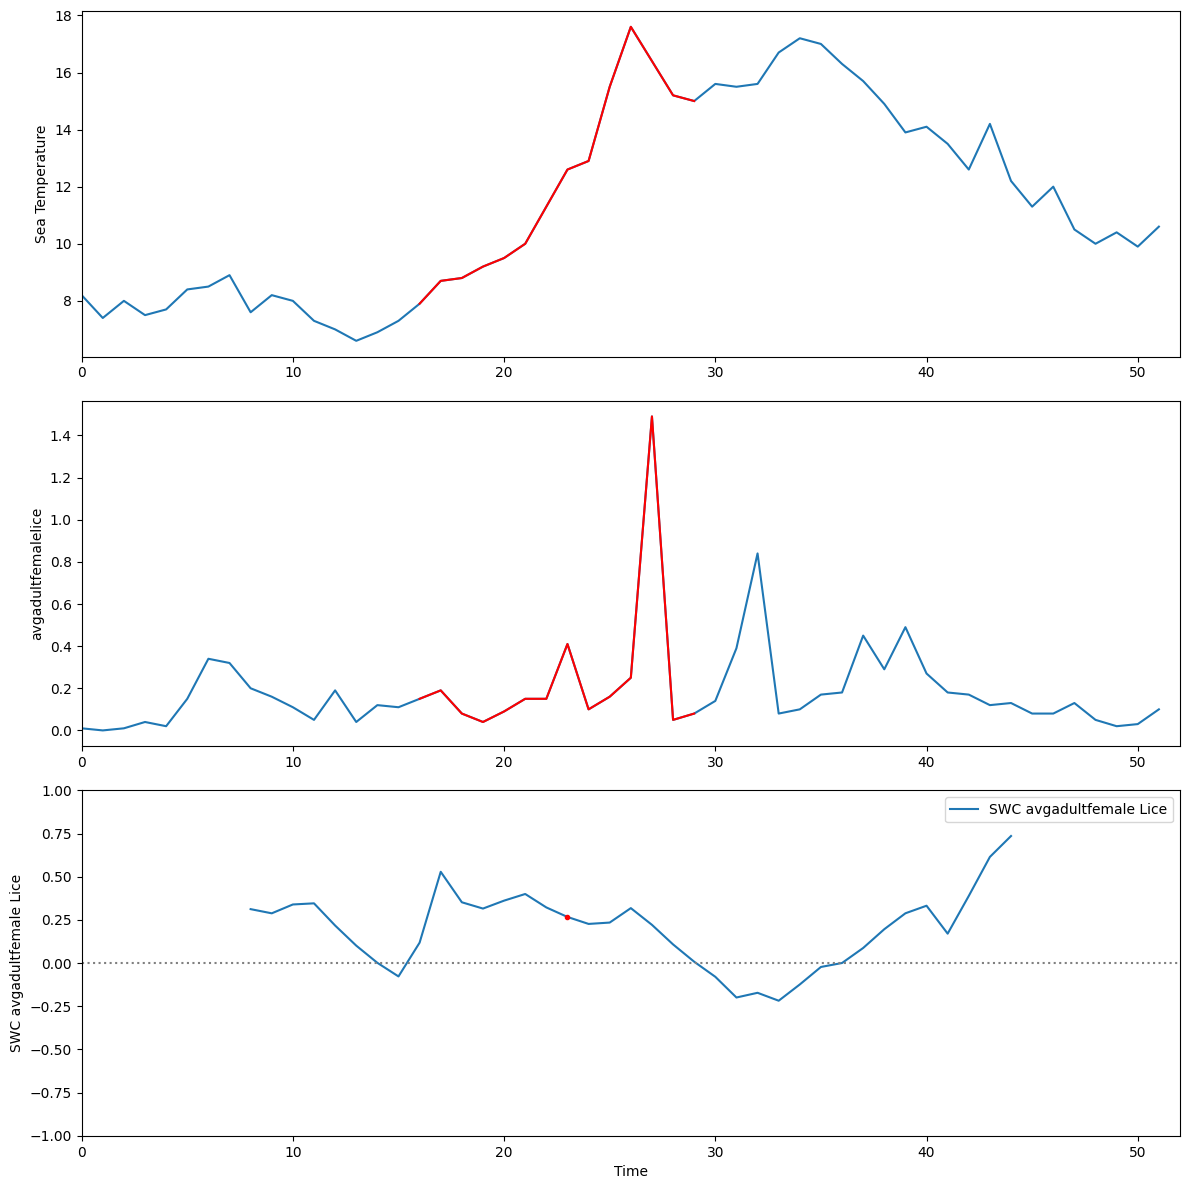

In [22]:
df = df_lice.copy()
df.index = df.index - 1
#Calculating sliding window correlation with lag
def calculate_sliding_window_correlation(df, column1, column2, window_size, lag):
    correlations = df[column1].rolling(window=window_size, center=True).corr(df[column2].shift(lag))
    return correlations

# Adjust window width and lag for each lice type
window_size = 15
lag = 1  # Adjusted for demonstration

# Calculate sliding window correlations
swc_adult_female = calculate_sliding_window_correlation(df, 'seatemperature', 'avgadultfemalelice', window_size, lag)

# Plotting function with interactive slider
center = 23
plt.figure(figsize=(12, 12))

# Plotting seaTemperature and highlighting center window
plt.subplot(3, 1, 1)
plt.plot(df['seatemperature'], label='Sea Temperature')
plt.plot(range(center - window_size//2, center + window_size//2), df['seatemperature'][center - window_size//2:center + window_size//2], color="red")
plt.ylabel('Sea Temperature')
plt.xlim(0, len(df['seatemperature']))

# Plotting avgadultfemalelice and highlighting center window
plt.subplot(3, 1, 2)
plt.plot(df['avgadultfemalelice'], label='avgadultfemalelice')
plt.plot(range(center - window_size//2, center + window_size//2), df['avgadultfemalelice'][center - window_size//2:center + window_size//2], color="red")
plt.ylabel('avgadultfemalelice')
plt.xlim(0, len(df['avgadultfemalelice']))

# Plotting Sliding Window Correlation for avgaadultfemalelice
plt.subplot(3, 1, 3)
plt.plot(swc_adult_female, label='SWC avgadultfemale Lice')
plt.plot(center, swc_adult_female[center], 'r.')
plt.axhline(y=0, color='gray', linestyle=':')
plt.ylim(-1, 1)
plt.xlim(0, len(df['seatemperature']))
plt.xlabel('Time')
plt.ylabel('SWC avgadultfemale Lice')
plt.legend()

plt.tight_layout()
plt.show()

For the averageadultfemale we see that if we utilize a big enough window, we get a mostly positive correlation. a more optimal value could probably be found.

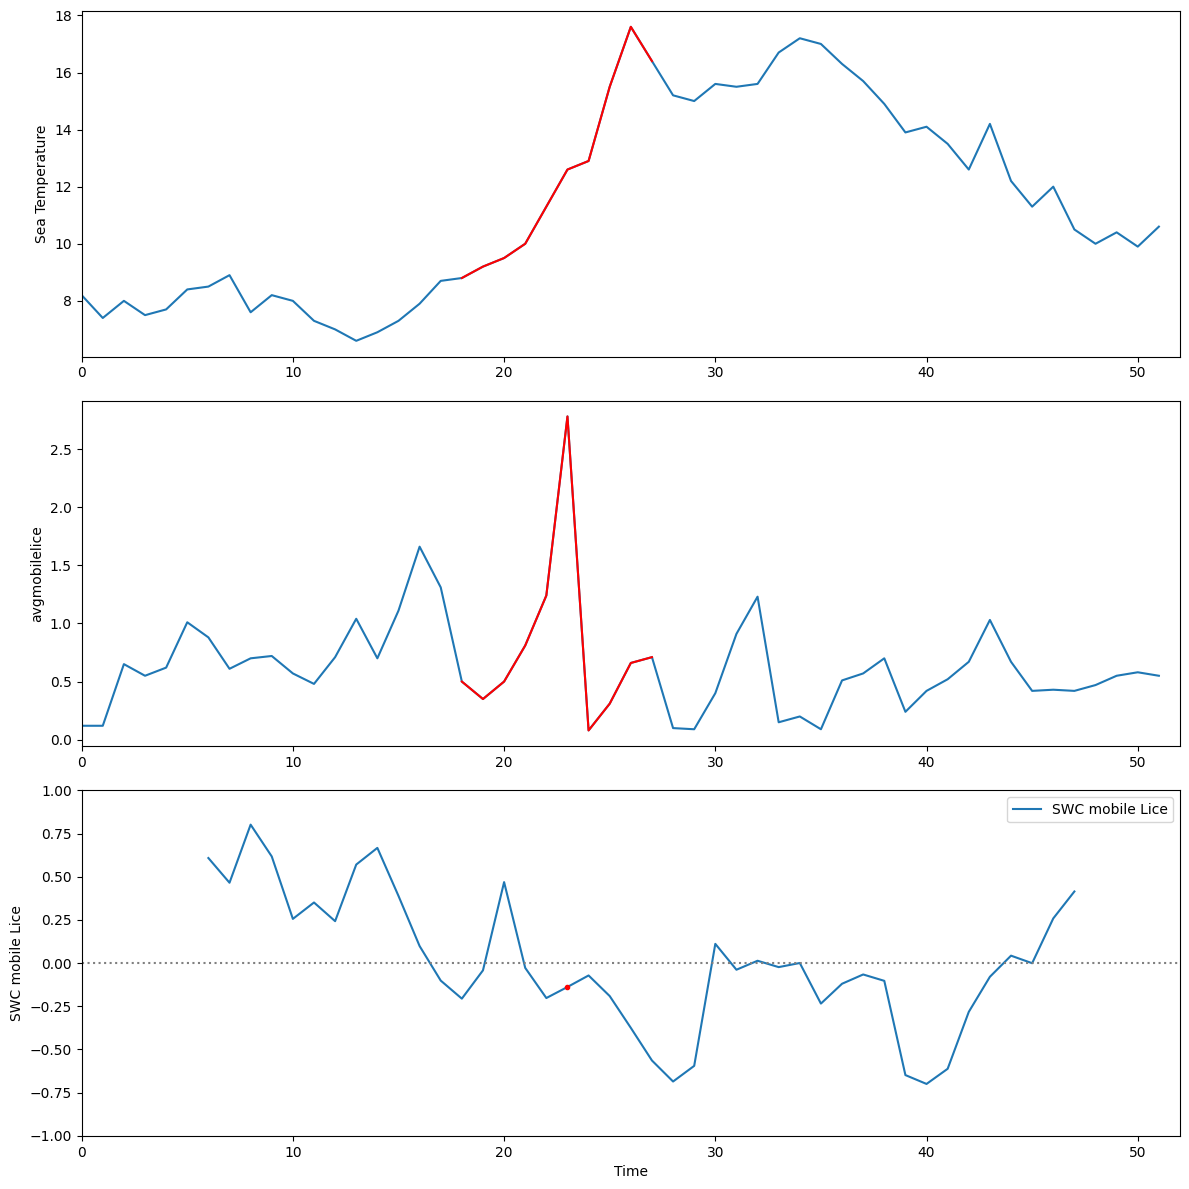

In [21]:
# do the same as above but for mobile lice
window_size = 10
lag = 1  # Adjusted for demonstration

# Calculate sliding window correlations

swc_mobile_lice = calculate_sliding_window_correlation(df, 'seatemperature', 'avgmobilelice', window_size, lag)

# Plotting function with interactive slider
plt.figure(figsize=(12, 12))

# Plotting seaTemperature and highlighting center window
plt.subplot(3, 1, 1)
plt.plot(df['seatemperature'], label='Sea Temperature')
plt.plot(range(center - window_size//2, center + window_size//2), df['seatemperature'][center - window_size//2:center + window_size//2], color="red")
plt.ylabel('Sea Temperature')
plt.xlim(0, len(df['seatemperature']))

# Plotting avgmobilelice and highlighting center window
plt.subplot(3, 1, 2)
plt.plot(df['avgmobilelice'], label='avgmobilelice')
plt.plot(range(center - window_size//2, center + window_size//2), df['avgmobilelice'][center - window_size//2:center + window_size//2], color="red")
plt.ylabel('avgmobilelice')
plt.xlim(0, len(df['avgmobilelice']))

# Plotting Sliding Window Correlation for avgmobilelice
plt.subplot(3, 1, 3)
plt.plot(swc_mobile_lice, label='SWC mobile Lice')
plt.plot(center, swc_mobile_lice[center], 'r.')
plt.axhline(y=0, color='gray', linestyle=':')
plt.ylim(-1, 1)
plt.xlim(0, len(df['seatemperature']))
plt.xlabel('Time')
plt.ylabel('SWC mobile Lice')
plt.legend()

plt.tight_layout()
plt.show()

This one proved more difficult to find good correlations

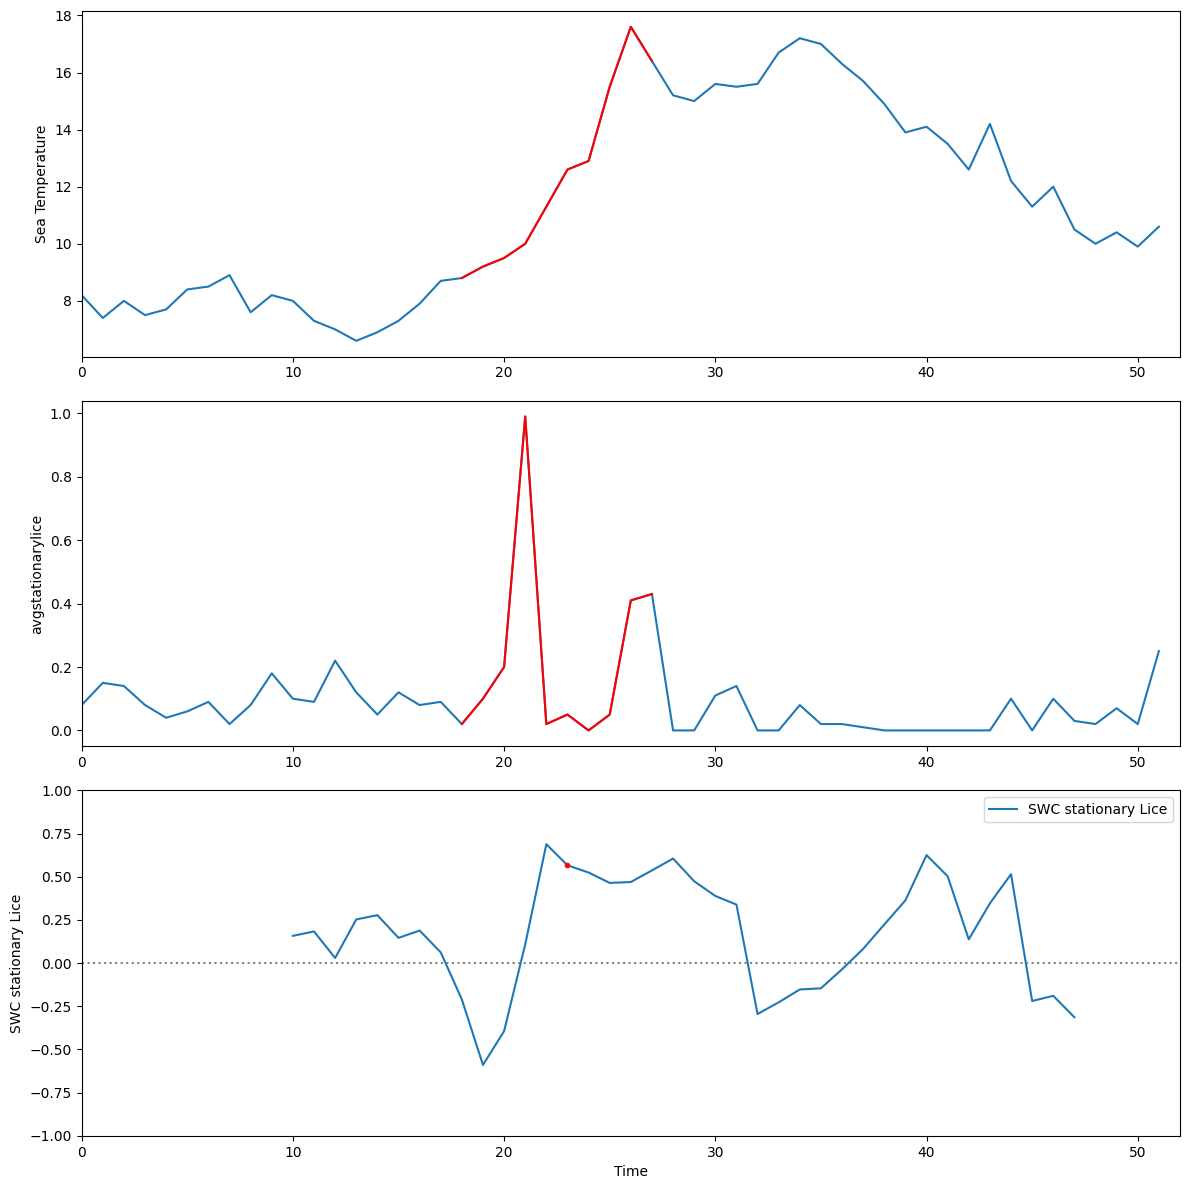

In [20]:
# do the same as above but for stationary lice
window_size = 10
lag = 5

# Calculate sliding window correlations

swc_stationary_lice = calculate_sliding_window_correlation(df, 'seatemperature', 'avgstationarylice', window_size, lag)


plt.figure(figsize=(12, 12))

# Plotting seaTemperature and highlighting center window
plt.subplot(3, 1, 1)
plt.plot(df['seatemperature'], label='Sea Temperature')
plt.plot(range(23 - window_size//2, 23 + window_size//2), df['seatemperature'][23 - window_size//2:23 + window_size//2], color="red")
plt.ylabel('Sea Temperature')
plt.xlim(0, len(df['seatemperature']))

# Plotting avgstationarylice and highlighting center window
plt.subplot(3, 1, 2)
plt.plot(df['avgstationarylice'], label='avgstationarylice')
plt.plot(range(23 - window_size//2, 23 + window_size//2), df['avgstationarylice'][23 - window_size//2:23 + window_size//2], color="red")
plt.ylabel('avgstationarylice')
plt.xlim(0, len(df['avgstationarylice']))

# Plotting Sliding Window Correlation for avgstationarylice
plt.subplot(3, 1, 3)
plt.plot(swc_stationary_lice, label='SWC stationary Lice')
plt.plot(23, swc_stationary_lice[23], 'r.')
plt.axhline(y=0, color='gray', linestyle=':')
plt.ylim(-1, 1)
plt.xlim(0, len(df['seatemperature']))
plt.xlabel('Time')
plt.ylabel('SWC stationary Lice')
plt.legend()

plt.tight_layout()
plt.show()

### ARIMAX

In [14]:
df_weatherlice = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_weather", keyspace="project_2").load()
df_weatherlice = df_weatherlice.toPandas()
df_weatherlice = df_weatherlice.sort_values(by=['week'])
df_weatherlice = df_weatherlice.set_index('week')
# drop lice
df_weatherlice.drop(['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'], axis=1, inplace=True)
# drop the smooth lice
df_weatherlice.drop(['smooth_avgadultfemalelice', 'smooth_avgmobilelice', 'smooth_avgstationarylice'], axis=1, inplace=True)
# index -1


# add the sea temperature column from df_lice
df_weatherlice['seatemperature'] = df_lice['seatemperature']
df_weatherlice.index = df_weatherlice.index - 1
df_weatherlice.head()


,air_temperature,precipitation_amount,relative_humidity,wind_speed,seatemperature
week,,,,,
0,2.860000,11.390000,82.599998,4.000000,8.2
1,3.542857,20.278570,82.571426,3.514286,7.4
2,3.792857,12.821428,77.571426,3.385714,8.0
3,3.907143,14.600000,80.857140,2.871429,7.5
4,2.778572,9.707144,76.285713,2.357143,7.7


In [15]:
# Creating lagged variables
df_lagged = df_weatherlice.shift(1)  # Shift by one week
df_lagged.columns = [f'{col}_lagged' for col in df_lagged.columns]
df_lagged.drop(['seatemperature_lagged'], axis=1, inplace=True)

# Merging the original and lagged dataframes
df_combined = pd.concat([df_weatherlice, df_lagged], axis=1)

# Dropping the first row as it contains NaN values due to lagging
df_combined.dropna(inplace=True)

df_combined.head()

,air_temperature,precipitation_amount,relative_humidity,wind_speed,seatemperature,air_temperature_lagged,precipitation_amount_lagged,relative_humidity_lagged,wind_speed_lagged
week,,,,,,,,,
1,3.542857,20.278570,82.571426,3.514286,7.4,2.860000,11.390000,82.599998,4.000000
2,3.792857,12.821428,77.571426,3.385714,8.0,3.542857,20.278570,82.571426,3.514286
3,3.907143,14.600000,80.857140,2.871429,7.5,3.792857,12.821428,77.571426,3.385714
4,2.778572,9.707144,76.285713,2.357143,7.7,3.907143,14.600000,80.857140,2.871429
5,2.100000,12.000000,75.857140,2.885714,8.4,2.778572,9.707144,76.285713,2.357143


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the target variable and exogenous variables
target = 'seatemperature'
exog_vars = df_weatherlice.columns.drop(target)

# Fitting the ARIMAX model
model = SARIMAX(df_weatherlice[target], exog=df_weatherlice[exog_vars], order=(1,1,1))
results = model.fit()

# Displaying the summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         seatemperature   No. Observations:                   52
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -63.125
Date:                Fri, 10 Nov 2023   AIC                            140.249
Time:                        11:56:40   BIC                            153.772
Sample:                             0   HQIC                           145.417
                                 - 52                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
air_temperature         -0.0523      0.058     -0.909      0.363      -0.165       0.060
precipitation_amount    -0.0037      0.016     -0.224      0.823      -0.036       0.029
relative_humidity        0.0037      0.024      0.155      0.877      -0.042       0.050
wind_speed               0.3190      0.177      1.804      0.071      -0.028       0.666
ar.L1                    0.7951      0.246      3.232      0.001       0.313       1.277
ma.L1                   -0.6276      0.351     -1.789      0.074      -1.315       0.060
sigma2                   0.6944      0.149      4.649      0.000       0.402       0.987
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.93   Prob(JB):                         0.79
Heteroskedasticity (H):               2.49   Skew:                            -0.18
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Wind seems seems to be the most significant variable, but none of them has a p value under 0.05.

In [17]:
# Defining the target variable and exogenous variables
target = 'seatemperature'
exog_vars = df_combined.columns.drop(target)

# Fitting the ARIMAX model
model2 = SARIMAX(df_combined[target], exog=df_combined[exog_vars], order=(1,1,1))
results2 = model2.fit()

# Displaying the summary of the model
results2.summary()

c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -56.534
Date:                Fri, 10 Nov 2023   AIC                            135.068
Time:                        11:56:43   BIC                            156.100
Sample:                             0   HQIC                           143.077
                                 - 51                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
air_temperature                -0.0101      0.055     -0.185      0.853      -0.117       0.097
precipitation_amount            0.0190      0.023      0.819      0.413      -0.026       0.064
relative_humidity              -0.0124      0.021     -0.583      0.560      -0.054       0.029
wind_speed                      0.1926      0.188      1.024      0.306      -0.176       0.561
air_temperature_lagged          0.1191      0.056      2.118      0.034       0.009       0.229
precipitation_amount_lagged     0.0383      0.020      1.870      0.062      -0.002       0.078
relative_humidity_lagged       -0.0362      0.023     -1.603      0.109      -0.080       0.008
wind_speed_lagged              -0.3738      0.175     -2.135      0.033      -0.717      -0.031
ar.L1                           0.7165      0.496      1.446      0.148      -0.255       1.688
ma.L1                          -0.5983      0.621     -0.964      0.335      -1.815       0.618
sigma2                          0.5527      0.164      3.361      0.001       0.230       0.875
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.71   Prob(JB):                         0.56
Heteroskedasticity (H):               1.72   Skew:                             0.26
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Including the lagged variables gave a better AIC. We can also see that the lagged variables have low p-values With both the air temperature and wind speed having significant values.

In [18]:
# Defining the target variable and exogenous variables
target = 'seatemperature'
exog_vars = df_combined.columns.drop([target,'air_temperature'])

# Fitting the ARIMAX model
model2 = SARIMAX(df_combined[target], exog=df_combined[exog_vars], order=(1,1,1))
results2 = model2.fit()

# Displaying the summary of the model
results2.summary()

c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\augus\miniconda3\envs\IND320\Lib\site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -56.480
Date:                Fri, 10 Nov 2023   AIC                            132.959
Time:                        11:56:45   BIC                            152.079
Sample:                             0   HQIC                           140.240
                                 - 51                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
precipitation_amount            0.0183      0.024      0.768      0.443      -0.028       0.065
relative_humidity              -0.0102      0.021     -0.484      0.628      -0.052       0.031
wind_speed                      0.1931      0.189      1.020      0.308      -0.178       0.564
air_temperature_lagged          0.1227      0.054      2.276      0.023       0.017       0.228
precipitation_amount_lagged     0.0347      0.020      1.711      0.087      -0.005       0.074
relative_humidity_lagged       -0.0312      0.022     -1.427      0.154      -0.074       0.012
wind_speed_lagged              -0.3344      0.182     -1.837      0.066      -0.691       0.022
ar.L1                           0.7688      0.452      1.702      0.089      -0.116       1.654
ma.L1                          -0.6561      0.570     -1.150      0.250      -1.774       0.462
sigma2                          0.5600      0.168      3.337      0.001       0.231       0.889
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.76   Prob(JB):                         0.63
Heteroskedasticity (H):               1.79   Skew:                             0.23
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dropping air temperature gave a bettwer AIC